The goal for this notebook is a streamlined, reproducable method of calculating the drift rates of all eligible planets in the NASA Exoplanet Database. 

There are 7 parameters necessary to calculate a planet's orbital drift rate: orbital period, semimajor axis, stellar mass, eccentricity, argument of periastron, inclination, and longitude of ascending node. As not all exoplanets have a measured value for each of these parameters, this notebook will provide methods to mitigate these insecurities.

In [25]:
#general utility packages
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import pandas as pd
from scipy.stats import beta

#nice modules from astropy
import astropy.units as u
import astropy.constants as const

#remind matplotlib how to do 3D plotting
from mpl_toolkits.mplot3d import Axes3D

#cool package that makes good ellipses
!pip install PyAstronomy
import PyAstronomy
from PyAstronomy import pyasl

#frequently used constants
pi = np.pi
G_units = const.G
G = 6.67 * 10 **(-11)
c_units = const.c
c = 3 * 10**8

## Data from the NASA Exoplanet Archive

The data I will be using for this project comes from the NASA Exoplanet Archive (NEA) which produces a nice spreadsheet. The column names I will be frequently using are:

Stellar Mass = st_mass

Planet Name = pl_name

Semimajor Axis = pl_orbsmax

Period in Days = pl_orbper

Eccentricity = pl_orbeccen

Inclination = pl_orbincl

Argument of Periapse = pl_orblper

In [2]:
#Downloade csv from NEA, currently at 4424 confirmed planets (7/10/21)
df_all = pd.read_csv('/Users/megan/Downloads/orbital_parameters_all.csv')

## Applying Kepler's Third Law

Kepler's Third Law relates 3 of our necessary parameters to each other: stellar mass, semimajor axis, and orbital period. Thus, calculations can be run on any planet with 2/3 of these parameters measured to get the third one. In this step, that is what I will do. 

Planets that only have 1 out of these 3 cannot be used in this project. All three of these parameters are not presumed to be nicely distributed across some bound numbers (like other parameters are,) so I have no current methods of simulating these values. As of 7/10/21, this is only 30 planets out of 4424 planets, so I am counting this as a negligible loss to our sample. This section of the code also saves the planets that are not eligible to a text file.

In [3]:
def keplers_third_law(df):
    trashed_planets = []
    df_solved = df
    for index, row in df_solved.iterrows():
        if pd.isna(row['pl_orbsmax']) == False and pd.isna(row['pl_orbper']) == False and pd.isna(row['st_mass']) == False:
        #All 3 values have numbers, don't need to be solved or dropped
            pass
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['pl_orbper']) == True:
            #2/3 missing, drop row
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['st_mass']) == True:
            #2/3 missing, drop row
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbper']) == True and pd.isna(row['st_mass']) == True:
            #2/3 missing, drop row  
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['pl_orbper']) == True and pd.isna(row['st_mass']) == True:
            #3/3 missing, drop row
            df_solved.drop(index = index, inplace = True)
            trashed_planets.append(row['pl_name'])
        elif pd.isna(row['pl_orbsmax']) == True and pd.isna(row['pl_orbper']) == False and pd.isna(row['st_mass']) == False:
            #only semimajor axis is missing
            df.loc[index, 'pl_orbsmax'] = (6.67*10**(-11) * row['st_mass'] * row['pl_orbper']**2 /(4*pi**2)) **(1/3)
            #Kepler's Third Law solved for semimajor axis
        elif pd.isna(row['pl_orbper']) == True and pd.isna(row['pl_orbsmax']) == False and pd.isna(row['st_mass']) == False:
            df.loc[index, 'pl_orbper'] = (4 * pi**2 * row['pl_orbsmax']**3/(6.67*10**(-11) * row['st_mass']))**(1/2)
            #Kepler's Third Law solved for period
        else:
            df.loc[index, 'st_mass'] = 4*pi**2*row['pl_orbsmax']**3/(6.67*10**(-11)*row['pl_orbper']**2)
            #Kepler's Third Law solved for stellar mass
    with open("trashed_planets.txt", "w") as file:
        file.write(str(trashed_planets))
        #saving the trashed planets to an external file
    return df_solved

In [6]:
df_kepler_solved = keplers_third_law(df_all)

## Randomly Assigned Values: Inclination, Argument of Periastron, and Longitude of Ascending Node

An orbit's inclination, argument of periastron, and longitude of ascending node essentially have no rhyme or reason to be distributed a certain way, so I will simulate missing values for these angles to be random across all possible values. That is, from 0 to 360 degrees for argument of periastron and longitude of ascending node, and from -90 to 90 degrees for inclination.

In [8]:
def assign_inclination(df):
    df_inc = df
    for index, row in df_inc.iterrows():
        random_inc = random.uniform(-90, 90)
        if pd.isna(row['pl_orbincl']) == True:
        #If the inclination is null    
            df.loc[index, 'pl_orbincl'] = random_inc
    return df_inc

In [10]:
df_kepler_inc = assign_inclination(df_kepler_solved)

In [13]:
def assign_arg_of_peri(df):
    df_aop = df
    for index, row in df_aop.iterrows():
        random_aop = random.uniform(0, 360)
        if pd.isna(row['pl_orblper']) == True:
        #If the argument of periastron is null    
            df.loc[index, 'pl_orblper'] = random_aop
    return df_aop

In [14]:
df_kepler_inc_aop = assign_arg_of_peri(df_kepler_inc)

In [23]:
#There are basically no measured longitudes of ascending node (only 4/4424, so I'll just randomly assign all of them)
def assign_long_of_asc_node(df):
    df_loan = df
    loans = []
    for index in df_loan.iterrows():
        random_loan = random.uniform(0, 360)
        loans.append(random_loan)
    df_loan['long_of_asc_node'] = loans
    return df_loan

In [24]:
df_kepler_inc_aop_loan = assign_long_of_asc_node(df_kepler_inc_aop)

## Eccentricity : Beta Distribution

For unmeasured eccentricities, I will be pulling numbers from a beta distribution as described in Kipping 2013.

In [26]:
def assign_ecc(df):
    df_ecc = df
    for index, row in df_ecc.iterrows():
        random_ecc = beta.rvs(0.867, 3.03)
        if pd.isna(row['pl_orbeccen']) == True:
        #If the eccentricity is null    
            df.loc[index, 'pl_orbeccen'] = random_ecc
    return df_ecc

In [27]:
df_all = assign_ecc(df_kepler_inc_aop_loan)
df_all.to_csv('all_orbital_parameters.csv')
#Our dataframe is complete, so I am saving it to a csv to avoid having multiple versions running around 
#as many of the values would change each time the code is run

## Calculating Drift Rates
Parameters should be in units of au, years, and degrees: 

e is the eccentricity of the orbit


omega is longitude of ascending node in degrees


i is inclination in degrees


w is argument is periapse in degrees


num_timestep is the number of data points to build the ellipse, I've been using 200

In [28]:
def drift_rates(semimajor, period, e, omega, i, w, stellar_mass, num_timestep):
    ke = pyasl.KeplerEllipse(semimajor, period, e, Omega = omega,i = i,w = w)
    # Build the ellipse
    t = np.linspace(0, period, num_timestep)
    # Make a time axis
    pos = ke.xyzPos(t)
    radius = ke.radius(t)
    total_acc = G*stellar_mass*u.Msun/(radius* u.au)**2
    z_acceleration_array = []
    vector_to_earth = [0,0,1]
    for i in range(0, num_timestep):
        position_vector = ke.xyzPos(t)[i,:]
        radius = ke.radius(t)
        # vector from the origin (host star) to the point in the orbit
        z_magnitude = np.dot(vector_to_earth, position_vector) / radius[i]
        # normalized magnitude of the vector in the observer's direction - between -1 and 1
        z_acceleration_array.append((z_magnitude * total_acc[i].si).value/c)
    return z_acceleration_array

In [29]:
df = pd.read_csv('all_orbital_parameters.csv')
#From now on, I'm only going to run this command to get the orbital parameters

In [43]:
cumulative_drift_rates = []
#Storing all the drift rates in this list to make plots later
for index, row in df.iterrows():
    drift_rates_list = drift_rates(row['pl_orbsmax'], row['pl_orbper']/365.25, row['pl_orbeccen'], row['long_of_asc_node'], row['pl_orbincl'], row['pl_orblper'], row['st_mass'], 200)
    print(index)
    for drift_rate in drift_rates_list:
        cumulative_drift_rates.append(drift_rate)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


## Plotting Tools

To visualize my drift rates, I will plot a series of varying histograms highlighting various aspects of the data. In this section, I will describe some tools I will use to enhance the plots.

In [40]:
def percentage_of_central_values(percent, list_):
    #This function will provide bounds on the histogram for an any percent of the values
    sorted_list = sorted(map(abs, list_))
    number_of_entries = round(len(list_) * percent/100)
    central_values = sorted_list[0:number_of_entries]
    return central_values

## Plots

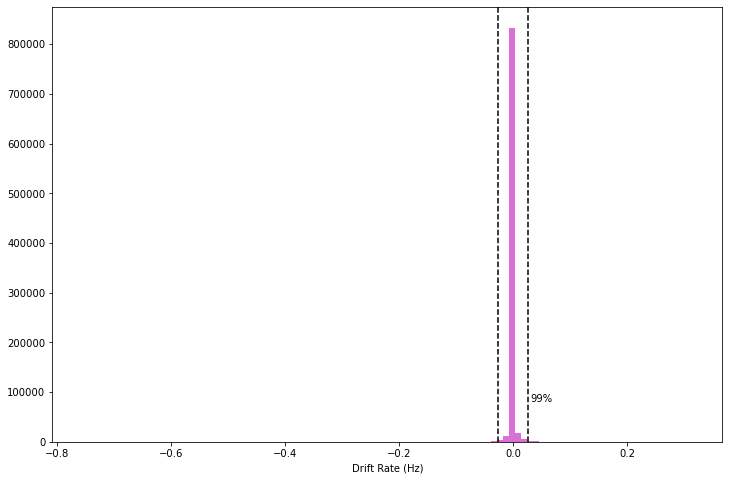

In [51]:
#Linearly Scaled Histogram with Central 50%
plt.figure(figsize = [12,8])
linear_markers = percentage_of_central_values(99, cumulative_drift_rates)
limit_linear = linear_markers[-1]
plt.hist(cumulative_drift_rates, color = 'orchid', bins = 100)
plt.axvline(x = limit_linear, color = 'k', linestyle = 'dashed')
plt.axvline(x = -limit_linear, color = 'k', linestyle = 'dashed')
plt.text(1.2*limit_linear, 8*10**4, '99%')
plt.xlabel('Drift Rate (Hz)')
plt.savefig('linear_histogram.png')
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'size'

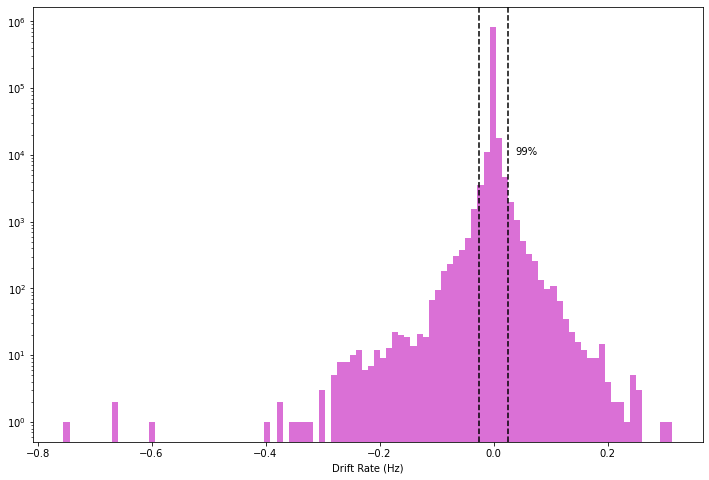

In [52]:
#Logarithmically Scaled Histogram with Central 99%
plt.figure(figsize = [12,8])
log_markers = percentage_of_central_values(99, cumulative_drift_rates)
limit_log = log_markers[-1]
plt.hist(cumulative_drift_rates, color = 'orchid', bins = 100)
plt.axvline(x = limit_log, color = 'k', linestyle = 'dashed')
plt.axvline(x = -limit_log, color = 'k', linestyle = 'dashed')
plt.text(1.5*limit_log, 10**4, '99%')
plt.xlabel('Drift Rate (Hz)')
plt.yscale('log')
plt.size([12,8])
plt.savefig('log_histogram.png')
plt.show()